In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
from pyigrf12 import gridigrf12
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt, convert
import ssusi_utils
%matplotlib inline

In [2]:
mapTime = datetime.datetime( 2015, 1, 5, 5 )#datetime.datetime( 2015, 4, 9, 7 )
vecsTime = datetime.datetime( 2015, 1, 5, 5 )#datetime.datetime( 2015, 4, 9, 5 )
pltCoords = 'mlt'
cntrPotMin = -35.
cntrPotMax = 5.
inpDst = -35.#-116#-5.
inpAsy = 30#100#20.
sapsProbCutoff = 0.2
delLatDist = 111. * 1e3 # 1 deg lat is 111 km
cntrLevels = numpy.linspace(cntrPotMin, cntrPotMax, 9, endpoint=True)

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
    # parameters from fitting
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []

for x in range( -7, 8 ):
    for y in range( -12, 10 ):        
        normLatArr.append( x )
        normMltArr.append( y )
        dstArr.append( inpDst )
        if y > 0:
            mltArr.append( y )
        else:
            mltArr.append( y + 24 )
        latArr.append( x + 57. )
        probSapsArr.append( saps_pred_func(x,y,inpDst) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= sapsProbCutoff\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-1,-2,0.200487,23,55.0,-35.0
1,0,-2,0.210837,24,55.0,-35.0
2,-3,-1,0.206607,21,56.0,-35.0
3,-2,-1,0.320829,22,56.0,-35.0
4,-1,-1,0.386799,23,56.0,-35.0


In [4]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func(asy):
    # parameters from fitting
    a_asy, b_asy = (-6.47, 9.48)
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

In [5]:
# To estimate the MLT variations we
# fit second order harmonics!
def mlt_fit_func(mlt, asy):
    # parameters from fitting
    c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b,\
                phiC1, phiS1 = (1.6959, -0.0039,\
                            1.4842, -0.0052, 76.9515, 0.3298,\
                            76.9763, 0.3271, 1.593, 0.807)
    
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    # Now get to the actual function
    phiC = (2*numpy.pi/24.) * mlt + phiC1
    phiS = (2*numpy.pi/24.) * mlt + phiS1
    cosTerm = c1 * numpy.cos(phiC)
    sinTerm = s1 * numpy.sin(phiS)
    cos2Term = c2 * numpy.cos(2*phiC)
    sin2Term = s2 * numpy.sin(2*phiS)
    return cosTerm + sinTerm + cos2Term + sin2Term

In [6]:
# MLAT varies with MLT and ASY. So we
# record MLAT variations as functions of
# MLT and Asy as well.
def mlat_mlt_fit_func(mlat, normMLT, asy):
    c0_a, c0_b, c0_c, c1_a, c1_b,\
        c1_c, c2_a, c2_b, c2_c = (0.04777, 0.00053,\
                0.00623, 0.85795, 0.00688, 0.06158,\
                0.07129, -0.00795, -0.07779)
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    c2 = c2_a + c2_b * asy + c2_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

In [7]:
def saps_pot_func( asy, mlt, mlat ):
    # Estimate SAPS potentials by
    # combining all the different 
    # functions.
    normMLT = mlt
    if mlt > 12.:
        normMLT = mlt - 24.
    phiSaps = peak_pot_fit_func(asy)
#     print "phiSaps", phiSaps
    mltSaps = mlt_fit_func(mlt, asy)
#     print "mltSaps", mltSaps
    mlatMLTSaps = mlat_mlt_fit_func(mlat, normMLT, asy)
#     print "mlat-mlt-Saps", mlatMLTSaps
    return -1.*phiSaps*mltSaps*mlatMLTSaps

In [8]:
predPotArr = []
predMlatArr = []
predMltArr = []
predNormMltArr = []
predAsyArr = []

for cpMLT in range(1,25):
    if cpMLT > 12.:
        currNormMlt = cpMLT - 24.
    else:
        currNormMlt = cpMLT
    currMLTMlats = sapsPredDF[ sapsPredDF["normMLT"]\
                              == currNormMlt\
                             ]["Lat"].values
#     print cpMLT, currMLTMlats
    if currMLTMlats.shape[0] < 2:
        continue
    # get normalized latitudes
    normMLTMLATs = currMLTMlats - numpy.min( currMLTMlats )
    normMLTMLATs = normMLTMLATs/numpy.max( normMLTMLATs )
    for indNorm, currNormMLAT in enumerate(normMLTMLATs):
        predPotArr.append( saps_pot_func(inpAsy, cpMLT, currNormMLAT) )
        predMlatArr.append( currMLTMlats[indNorm] )
        predAsyArr.append( inpAsy )
        predNormMltArr.append( currNormMlt )
        predMltArr.append(cpMLT)

# for cpMLT in range(25):
#     for cpMlat in range(53,65,1):
#         predMlatArr.append( cpMlat )
#         predAsyArr.append( inpAsy )
#         # Fit params
#         predPotArr.append( saps_pot_func(inpAsy, cpMLT, cpMlat) )
#         if cpMLT > 12.:
#             normMlt = cpMLT - 24.
#         else:
#             normMlt = cpMLT
#         predNormMltArr.append( normMlt )
#         predMltArr.append(cpMLT)
    
predPotDF = pandas.DataFrame({
                "potential" : predPotArr,
                "Lat" : predMlatArr,
                "AsyH" : predAsyArr,
                "normMLT" : predNormMltArr,
                "MLT" : predMltArr
                })
predPotDF = predPotDF.drop_duplicates()

In [9]:
# selSapsPredDF = sapsPredDF[ sapsPredDF["dst_index"] == inpDst ].reset_index(drop=True)
# # predPotDF = predPotDF.merge( selSapsPredDF,\
# #                             on=[ "Lat", "MLT", "normMLT" ],\
# #                             how="inner" )
# # predPotDF = predPotDF.drop_duplicates()
# # print predPotDF["potential"].min()
# pltDF = predPotDF[ ["Lat", "normMLT",\
#                         "potential"] ]#.pivot( "Lat", "normMLT" )
# print pltDF
# print predPotDF

[18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 0.0, 1.0] [ 268.81295193  283.81295193  298.81295193  313.81295193  328.81295193
  343.81295193  358.81295193   13.81295193]


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


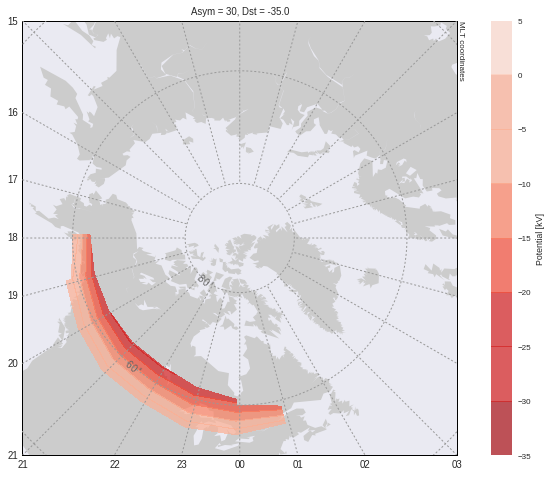

In [10]:
# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))

pltDF = predPotDF[ ["Lat", "normMLT",\
                        "potential"] ].pivot( "Lat", "normMLT" )

mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x+24. if x < 0. else x for x in nrmMltsPot ]
mlonPots = convert_mlt( mltsPot, vecsTime , m2a=True )
mlonPots = mlonPots #+ 90.
print mltsPot, mlonPots
potVals=pltDF.values
#         nanLocs = numpy.isnan(potVals)
#         potVals[nanLocs] = 0
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
mlonsPotCntr, mlatsPotCntr  = numpy.meshgrid( mlonPots, mlatsPot )

ax = fig.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax, lat_0=90.,\
                            lon_0=0., datetime=mapTime)

# remove the background map
# mapCommonColor = "0.95"
# m1.fillcontinents(color=mapCommonColor, lake_color=mapCommonColor)
# m1.drawmapboundary(fill_color=mapCommonColor)
# m1.drawcoastlines(color=mapCommonColor)



xVec, yVec = m1(mlonsPotCntr, mlatsPotCntr, coords=pltCoords)
cntrPlt = m1.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 5., alpha=0.7,\
    cmap=seaMap, ax=ax);

ax.set_title( "Asym = " + str(inpAsy) +\
            ", Dst = " + str(inpDst) )
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('Potential [kV]')
# cntrPlt.clim( cntrPotMin, cntrPotMax )
fig.savefig("../figs/potValidate.pdf",bbox_inches='tight')

In [11]:
predPotDF["Mlon"] = convert_mlt( predPotDF["MLT"].values, vecsTime , m2a=True )
predPotDF["date"] = vecsTime

In [12]:
def get_geo_coords(row):
    glat, glon = convert( row["Lat"], row["Mlon"] , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

predPotDF["gcoord"] = predPotDF.apply( get_geo_coords, axis=1 )
predPotDF["glat"] = [ float( x.split("__")[0] ) for x in predPotDF["gcoord"] ]
predPotDF["glon"] = [ float( x.split("__")[1] ) for x in predPotDF["gcoord"] ]
predPotDF.head()

,AsyH,Lat,MLT,normMLT,potential,Mlon,date,gcoord,glat,glon
0,30,56.0,1,1.0,-1.316383,13.812952,2015-01-05 05:00:00,47.4067904073__-67.1978168495,47.406790,-67.197817
1,30,57.0,1,1.0,-7.871705,13.812952,2015-01-05 05:00:00,48.4281324547__-67.2792524407,48.428132,-67.279252
2,30,58.0,1,1.0,-13.401709,13.812952,2015-01-05 05:00:00,49.4492217248__-67.3622631643,49.449222,-67.362263
3,30,59.0,1,1.0,-17.906394,13.812952,2015-01-05 05:00:00,50.4704042503__-67.4473481846,50.470404,-67.447348
4,30,60.0,18,-6.0,-0.482036,268.812952,2015-01-05 05:00:00,59.4274207205__-149.376488494,59.427421,-149.376488


In [13]:
# Arrays to store potential
potPotArr = []
potVelArr = []
potMltArr = []
potNrmMltArr = []
potMlatArr = []
potMlonArr = []
potEfldArr = []
bFldArr = []

# we'll adjust the first and last MLTs
# to reduce the velocities. Since the 
# latitudinal extent reduces at the edges
# we see higher velocities
maxNormMLT = predPotDF["normMLT"].max()
minNormMLT = predPotDF["normMLT"].min()
for cmlt in predPotDF["normMLT"].unique().tolist():
    
    # Get Uniq Lats at the MLT!
    selMltDF = predPotDF[ predPotDF["normMLT"] == cmlt ]
    # At each MLT we assume potential is zero at the lowest
    # latitude!
    if cmlt < 0:
        actMLT = cmlt + 24.
    else:
        actMLT = cmlt
    mlatList = -numpy.sort( -selMltDF["Lat"].unique() )
    delMlats = numpy.gradient(mlatList)
    
    for mlatInd, cMlat in enumerate( mlatList ):
        if mlatInd + 1 < selMltDF.shape[0]:
            nextLat = mlatList[ mlatInd + 1 ]
            nxtLatsDF = selMltDF[ (selMltDF["Lat"] == nextLat) ]
            nxtLatPot = nxtLatsDF["potential"].values[0]*1e3
        else:
            nxtLatPot = 0.
        selLatsDF = selMltDF[ (selMltDF["Lat"] == cMlat) ]
        currMlon = selLatsDF["Mlon"].values[0]
        currPot = selLatsDF["potential"].values[0]*1e3 # convert to volts from kV
        delPot = currPot - nxtLatPot
        if (cmlt == maxNormMLT) or (cmlt == minNormMLT):
            currEfield = abs(delPot/(delLatDist*1.75)) # In V/m
        else:
            currEfield = abs(delPot/delLatDist) # In V/m
        Bx,By,Bz,Bf, yeardec = gridigrf12( selLatsDF["date"].values[0],\
                                    0, 1, 300., selLatsDF["glat"].values[0],\
                                    selLatsDF["glon"].values[0] )
        currVel = currEfield/(Bf[0]*1e-9)
        potVelArr.append( currVel )
        potPotArr.append( currPot/1e3 )
        potMltArr.append( actMLT )
        potNrmMltArr.append( cmlt )
        potMlatArr.append( cMlat )
        potMlonArr.append( currMlon )
        potEfldArr.append( currEfield*1e3 )
        bFldArr.append(Bf[0])

        
velPotDF = pandas.DataFrame({
            "normMLT" : potNrmMltArr,
            "MLAT" : potMlatArr,
            "MLT" : potMltArr,
            "eSAPS" : potEfldArr,
            "MLON" : potMlonArr,
            "vSAPS" : potVelArr,
            "potential" : potPotArr,
            "BField" : bFldArr
            })
velPotDF = velPotDF.round(2)
velPotDF.to_csv( "../data/sample-vel-pred.csv", index=None, header=None, sep=" " )
feather.write_dataframe(velPotDF, '../data/predVels-' + mapTime.strftime("%Y%m%d") + '.feather')


In [14]:
velPotDF["azimSAPS"] = 0.
velPotDF["endPtMLAT"] = numpy.round( (velPotDF["vSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["MLAT"], 2)
velPotDF["endPtNormMLT"] = numpy.round( (velPotDF["vSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["normMLT"], 2)
velPotDF["endPtMlon"] = numpy.round( (velPotDF["vSAPS"]/100.) *\
                                numpy.sin( numpy.deg2rad(-90-1*velPotDF["azimSAPS"]) ) +\
                                velPotDF["MLON"], 2)
print velPotDF

      BField  MLAT    MLON   MLT  eSAPS  normMLT  potential   vSAPS  azimSAPS  \
0   47452.74  59.0   13.81   1.0  23.19      1.0     -17.91  488.70       0.0   
1   47141.47  58.0   13.81   1.0  28.47      1.0     -13.40  603.89       0.0   
2   46811.65  57.0   13.81   1.0  33.75      1.0      -7.87  720.91       0.0   
3   46463.59  56.0   13.81   1.0   6.78      1.0      -1.32  145.85       0.0   
4   48854.06  63.0  268.81  18.0  37.57     -6.0     -18.71  769.03       0.0   
5   48567.41  62.0  268.81  18.0  31.29     -6.0     -11.42  644.20       0.0   
6   48259.35  61.0  268.81  18.0  25.00     -6.0      -5.34  518.13       0.0   
7   47930.22  60.0  268.81  18.0   2.48     -6.0      -0.48   51.77       0.0   
8   49247.47  63.0  283.81  19.0  46.57     -5.0     -22.61  945.60       0.0   
9   48975.40  62.0  283.81  19.0  42.99     -5.0     -17.44  877.87       0.0   
10  48681.48  61.0  283.81  19.0  39.42     -5.0     -12.66  809.75       0.0   
11  48366.05  60.0  283.81  

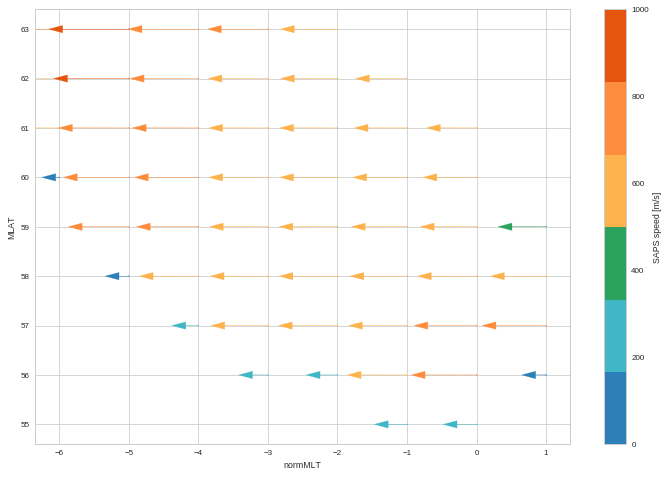

In [15]:
velPotDF["SAPS speed [m/s]"] = velPotDF["vSAPS"]
plotMLTends = velPotDF['endPtNormMLT'].tolist()
plotMLATends = velPotDF['endPtMLAT'].tolist()
plotMLTbegins = velPotDF['normMLT'].tolist()
plotMLATbegins = velPotDF['MLAT'].tolist()
plotVelMagns = velPotDF['SAPS speed [m/s]'].tolist()

velScaleMin = 0.
velScaleMax = 1000.

# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
velPotDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='SAPS speed [m/s]',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)

colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)

In [16]:
# SSUSI DATA
inpDir = "../data/ssusi/"
fileDate = mapTime
inpTime = mapTime
ssObj = ssusi_utils.UtilsSsusi( inpDir, fileDate )

fDict = ssObj.filter_data_by_time(inpTime, timeDelta=40)

reading data from---> ../data/ssusi/F18/20150105.txt
reading data from---> ../data/ssusi/F17/20150105.txt
reading data from---> ../data/ssusi/F16/20150105.txt


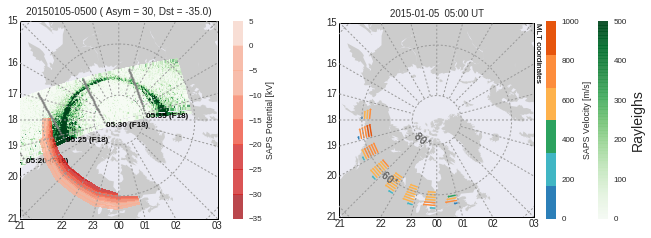

In [20]:
velPotDF["SAPS speed [m/s]"] = velPotDF["vSAPS"]
plotMLONends = velPotDF['endPtMlon'].tolist()
plotMLATends = velPotDF['endPtMLAT'].tolist()
plotMLONbegins = velPotDF['MLON'].tolist()
plotMLATbegins = velPotDF['MLAT'].tolist()
plotVelMagns = velPotDF['SAPS speed [m/s]'].tolist()

velScaleMin = 0.
velScaleMax = 1000.

colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
velSeaMap = ListedColormap(sns.color_palette(colors))

# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))

pltDF = predPotDF[ ["Lat", "normMLT",\
                        "potential"] ].pivot( "Lat", "normMLT" )

mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x+24. if x < 0. else x for x in nrmMltsPot ]
mlonPots = convert_mlt( mltsPot, vecsTime , m2a=True )
potVals=pltDF.values
#         nanLocs = numpy.isnan(potVals)
#         potVals[nanLocs] = 0
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
mlonsPotCntr, mlatsPotCntr  = numpy.meshgrid( mlonPots, mlatsPot )

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
m1 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax1, lat_0=90.,\
                            lon_0=0., datetime=mapTime)
m2 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax2, lat_0=90.,\
                            lon_0=0., datetime=mapTime)

ssObj.overlay_sat_data( fDict, m1, ax1, satList=["F18"],\
             inpTime=inpTime, vmin=0., vmax=500.,\
                       autoScale=False, plotCBar=True )

xVec, yVec = m1(mlonsPotCntr, mlatsPotCntr, coords=pltCoords)
cntrPlt = m1.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 8., alpha=0.75,\
    cmap=seaMap, ax=ax1);
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels,ax=ax1)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('SAPS Potential [kV]')
# Plot SSUSI
# ssObj.overlay_sat_data( fDict, m2, ax2, satList=["F17"],\
#              inpTime=inpTime, vmin=0., vmax=1000.,\
#                        autoScale=False, plotCBar=False )

colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMlonend, currMLATend, currMlonbgn, currMLATbgn, currVel in\
        zip( plotMLONends, plotMLATends, plotMLONbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = velSeaMap( colNorm(currVel) )
        currXVecBgn, currYVecBgn = m2(currMlonbgn, currMLATbgn, coords=pltCoords)
        currXVecEnd, currYVecEnd = m2(currMlonend, currMLATend, coords=pltCoords)
        velPlot = ax2.plot( [currXVecBgn, currXVecEnd], [ currYVecBgn, currYVecEnd ], color=currCol )     
        ax2.arrow( currXVecBgn, currYVecBgn, currXVecEnd-currXVecBgn, currYVecEnd-currYVecBgn,\
                 head_width=1e5, head_length=5e4, fc=currCol, ec=currCol)

printText = mapTime.strftime("%Y%m%d-%H%M") + " ( Asym = " + str(inpAsy) + ", Dst = " + str(inpDst) + ")"
ax1.set_title(printText, fontsize=10)
# ax1.text(0.1, 0.9,  printText,
#             transform=ax1.transAxes,
#             color='#2c7fb8', fontsize=8)
# ax1.text(0.1, 0.9,  printText,
#             transform=ax1.transAxes,
#             color='#2c7fb8', fontsize=8)



sm = plt.cm.ScalarMappable(cmap=velSeaMap, norm=Normalize(vmin=velScaleMin, vmax=velScaleMax))
sm._A = []
plt.colorbar(sm, ax=ax2)
sm.colorbar.ax.set_ylabel('SAPS Velocity [m/s]')
fig.savefig("../figs/pot-vels-estimates.pdf",bbox_inches='tight')